In [4]:
pip install --upgrade numpy scipy matplotlib pandas bioread

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 132.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 120.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.0 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=cda051b9177617a8a8f9dc573c8b7389892e47e186ff050c9fe781bd20abe709
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
Successfully built docopt
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: pandas
    Found existin

------------------------NEW CODE ------------------------

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bioread
from scipy.signal import butter, filtfilt, iirnotch, welch



# LOADING FILE
def load_acq(file_path):
    data = bioread.read_file(file_path)
    ch = data.channels[0]     # EMG channel
    emg = ch.data.astype(float)
    fs = ch.samples_per_second
    t = np.arange(len(emg)) / fs
    return emg, fs, t



# FILTERING, ENVELOPE
def rms_envelope(sig, fs, win_ms=20):
    win = int(win_ms / 1000 * fs)
    if win < 1:
        win = 1
    env = np.sqrt(np.convolve(sig**2, np.ones(win)/win, mode="same"))
    return env

def preprocess_emg(raw, fs):
    highcut = min(200, fs/2 - 1)
    b, a = butter(4, [20, highcut], btype='bandpass', fs=fs)
    emg_bp = filtfilt(b, a, raw)

    b_notch, a_notch = iirnotch(50, Q=30, fs=fs)
    emg_notch = filtfilt(b_notch, a_notch, emg_bp)

    emg_rect = np.abs(emg_notch)

    b_env, a_env = butter(4, 5, btype='lowpass', fs=fs)
    emg_env = rms_envelope(emg_notch, fs)

    return emg_notch, emg_rect, emg_env


# ACTIVITY DETECTION
def detect_activity_intervals(env, fs, min_duration=0.3):
    """
    Robust activity detection based on envelope percentiles.
    Works well for your data (clear bursts vs rest).
    Returns:
      intervals: list of (start_idx, end_idx)
      thr: threshold used
    """

    low = np.percentile(env, 10)
    high = np.percentile(env, 90)

    thr = low + 0.05 * (high - low)

    active = env > thr

    intervals = []
    start = None

    for i, a in enumerate(active):
        if a and start is None:
            start = i
        elif not a and start is not None:
            dur = (i - start) / fs
            if dur >= min_duration:
                intervals.append((start, i))
            start = None

    if start is not None:
        dur = (len(active) - start) / fs
        if dur >= min_duration:
            intervals.append((start, len(active)))

    print(f"Threshold = {thr:.4f}, detected {len(intervals)} bursts")
    return intervals, thr



# FEATURE EXTRACTION
def compute_rms(x): return np.sqrt(np.mean(x**2))
def compute_mav(x): return np.mean(np.abs(x))

def compute_mdf(x, fs):
    f, Pxx = welch(x, fs=fs, nperseg=min(1024, len(x)))
    cumsum = np.cumsum(Pxx)
    return f[np.where(cumsum >= cumsum[-1]/2)[0][0]]

def compute_tremor_power(x, fs, band=(8,12)):
    f, Pxx = welch(x, fs=fs, nperseg=min(1024, len(x)))
    mask = (f>=band[0]) & (f<=band[1])
    return np.trapezoid(Pxx[mask], f[mask])

def extract_features_auto(emg, intervals, fs):
    rows = []
    for idx, (s, e) in enumerate(intervals):
        seg = emg[s:e]
        rows.append({
            "burst": idx+1,
            "start_s": s/fs,
            "end_s": e/fs,
            "duration": (e-s)/fs,
            "rms": compute_rms(seg),
            "mav": compute_mav(seg),
            "mdf": compute_mdf(seg, fs),
            "tremor_power": compute_tremor_power(seg, fs)
        })
    return pd.DataFrame(rows)


def plot_segmentation(emg, env, intervals, fs, title="Segmentation Debug"):
    t = np.arange(len(emg))/fs
    plt.figure(figsize=(12,5))
    plt.plot(t, env, label="Envelope")

    for (s,e) in intervals:
        plt.axvspan(s/fs, e/fs, color='red', alpha=0.2)

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.legend()
    plt.grid(True)
    plt.show()


# SHORT PROTOCOL

def process_short_auto(file_path, condition):

    raw, fs, t = load_acq(file_path)
    clean, rect, env = preprocess_emg(raw, fs)

    # detect bursts
    bursts, thr = detect_activity_intervals(env, fs, min_duration=1.5)
    plot_segmentation(clean, env, bursts, fs, title="Short File Segmentation")

    # extract features
    features = extract_features_auto(clean, bursts, fs)
    features["condition"] = condition

    mid_time = t[-1] / 2.0

    # lift vs clench label based on segment start time
    labels = []
    lift_count = 0
    clench_count = 0

    for _, row in features.iterrows():
        start = row["start_s"]
        if start < mid_time:
            lift_count += 1
            labels.append(f"lift{lift_count}")
        else:
            clench_count += 1
            labels.append(f"clench{clench_count}")

    features["label"] = labels

    labelled_segments = {}
    for (s, e), lab in zip(bursts, labels):
        labelled_segments[lab] = clean[s:e]

    return {
        "raw": raw,
        "clean": clean,
        "env": env,
        "fs": fs,
        "t": t,
        "bursts": bursts,
        "segments": labelled_segments,
        "features": features
    }


# LONG PROTOCOL
def process_long_auto(file_path, condition):
    raw, fs, t = load_acq(file_path)
    clean, rect, env = preprocess_emg(raw, fs)

    bursts, thr = detect_activity_intervals(env, fs, min_duration=11.0)
    plot_segmentation(clean, env, bursts, fs, title="Long File Segmentation")

    if len(bursts) == 0:
        raise RuntimeError("No activity detected in long protocol.")

    # merging the segments in case there is more than one
    s = bursts[0][0]
    e = bursts[-1][1]
    long_seg = clean[s:e]

    # Fatigue curve
    bin_size = int(5 * fs)
    num_bins = len(long_seg) // bin_size
    mdf_curve = []
    for i in range(num_bins):
        chunk = long_seg[i*bin_size : (i+1)*bin_size]
        mdf_curve.append(compute_mdf(chunk, fs))
    mdf_curve = np.array(mdf_curve)

    features = pd.DataFrame({
        "segment": ["long_task"],
        "rms": [compute_rms(long_seg)],
        "mav": [compute_mav(long_seg)],
        "mdf": [compute_mdf(long_seg, fs)],
        "tremor_power": [compute_tremor_power(long_seg, fs)],
        "condition": condition
    })

    return {
        "raw": raw,
        "clean": clean,
        "env": env,
        "fs": fs,
        "t": t,
        "burst": (s, e),
        "long_seg": long_seg,
        "features": features,
        "mdf_curve": mdf_curve
    }

Threshold = 0.0144, detected 8 bursts


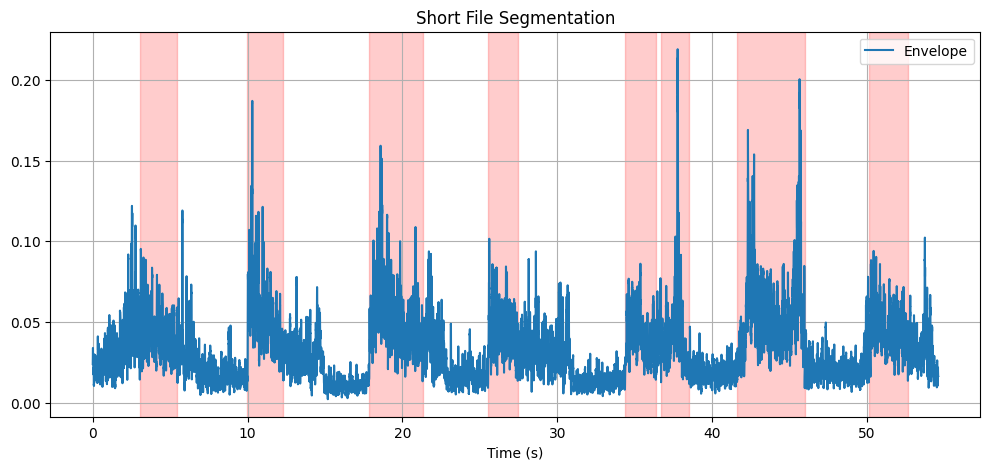

   burst  start_s   end_s  duration       rms       mav         mdf  \
0      1    3.042   5.458     2.416  0.044877  0.034655  113.281250   
1      2    9.988  12.314     2.326  0.060956  0.045566  120.117188   
2      3   17.820  21.302     3.482  0.059209  0.044653  110.839844   
3      4   25.536  27.450     1.914  0.047180  0.036793  112.852665   
4      5   34.384  36.368     1.984  0.043950  0.034504   74.092742   
5      6   36.708  38.526     1.818  0.054706  0.038272   42.354235   
6      7   41.634  45.984     4.350  0.063730  0.047724   94.726562   
7      8   50.120  52.650     2.530  0.049719  0.039552   97.167969   

   tremor_power condition    label  
0  9.340947e-10  caffeine    lift1  
1  7.750005e-11  caffeine    lift2  
2  2.737874e-10  caffeine    lift3  
3  7.632569e-10  caffeine    lift4  
4  6.335340e-10  caffeine  clench1  
5  6.867840e-09  caffeine  clench2  
6  2.554774e-09  caffeine  clench3  
7  4.917691e-10  caffeine  clench4  


In [4]:
Z1 = process_short_auto("/content/BSP_Project_EMG_Caffeine-Zalan-1.acq", "caffeine")
print(Z1["features"])

Threshold = 0.0150, detected 5 bursts


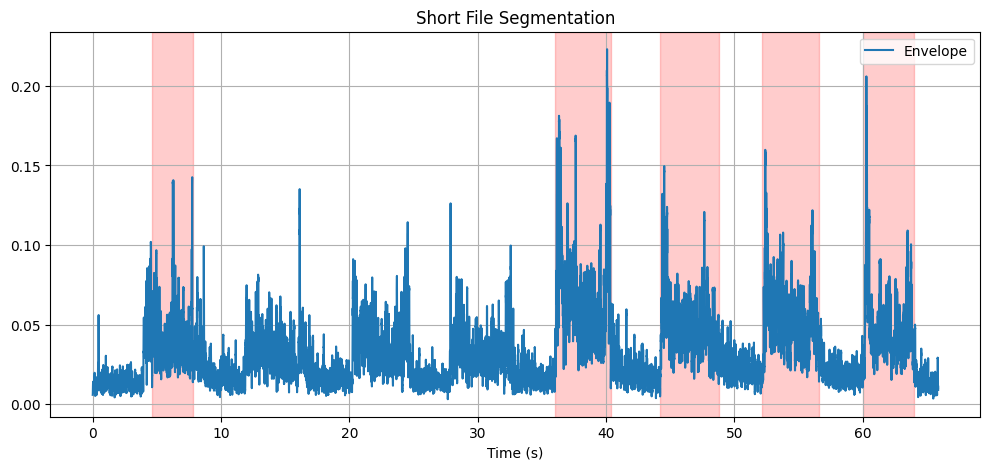

   burst  start_s   end_s  duration       rms       mav         mdf  \
0      1    4.624   7.798     3.174  0.046265  0.034029  122.070312   
1      2   36.006  40.364     4.358  0.076460  0.057285   95.703125   
2      3   44.220  48.772     4.552  0.053810  0.041281   93.261719   
3      4   52.182  56.584     4.402  0.058272  0.045302   92.285156   
4      5   59.978  64.004     4.026  0.054846  0.040871   87.402344   

   tremor_power condition    label  
0  3.450662e-10   placebo    lift1  
1  4.525731e-09   placebo  clench1  
2  2.613511e-09   placebo  clench2  
3  1.517622e-09   placebo  clench3  
4  1.109312e-09   placebo  clench4  


In [5]:
Z2 = process_short_auto("/content/BSP_Project_EMG_Caffeine-Zalan-2.acq", "placebo")
print(Z2["features"])

Threshold = 0.0067, detected 4 bursts


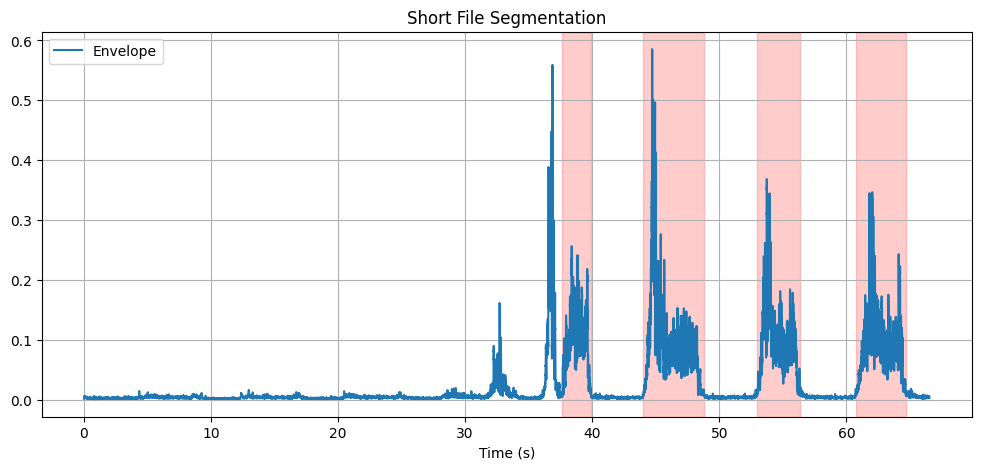

   burst  start_s   end_s  duration       rms       mav        mdf  \
0      1   37.648  39.908     2.260  0.114203  0.083068  76.171875   
1      2   44.012  48.792     4.780  0.127826  0.082643  76.660156   
2      3   52.988  56.330     3.342  0.119432  0.084369  86.914062   
3      4   60.764  64.704     3.940  0.113658  0.081645  88.867188   

   tremor_power condition    label  
0  2.572494e-09   placebo  clench1  
1  8.789613e-09   placebo  clench2  
2  2.637326e-08   placebo  clench3  
3  7.593778e-09   placebo  clench4  


In [6]:
B1 = process_short_auto("/content/BSP_Project_EMG_Caffeine-Benedek-1.acq", "placebo")
print(B1["features"])

Threshold = 0.0090, detected 5 bursts


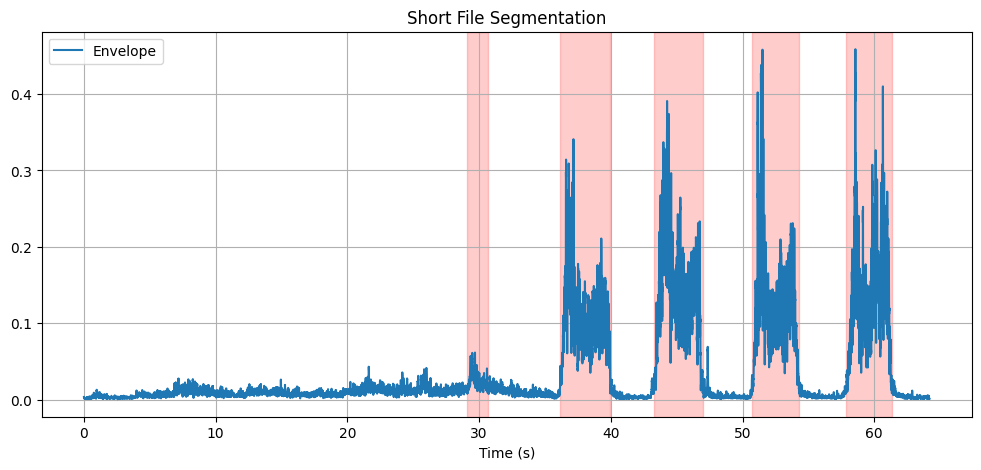

   burst  start_s   end_s  duration       rms       mav         mdf  \
0      1   29.114  30.650     1.536  0.027885  0.021189  119.791667   
1      2   36.130  39.966     3.836  0.120907  0.090160   86.914062   
2      3   43.266  47.026     3.760  0.152927  0.112280   83.984375   
3      4   50.698  54.290     3.592  0.138944  0.101293   75.195312   
4      5   57.858  61.336     3.478  0.155006  0.112521   76.171875   

   tremor_power condition    label  
0  3.507265e-10  caffeine    lift1  
1  2.977390e-08  caffeine  clench1  
2  1.742109e-08  caffeine  clench2  
3  1.848817e-08  caffeine  clench3  
4  3.471833e-08  caffeine  clench4  


In [7]:
B2 = process_short_auto("/content/BSP_Project_EMG_Caffeine-Benedek-2.acq", "caffeine")
print(B2["features"])

Threshold = 0.0124, detected 4 bursts


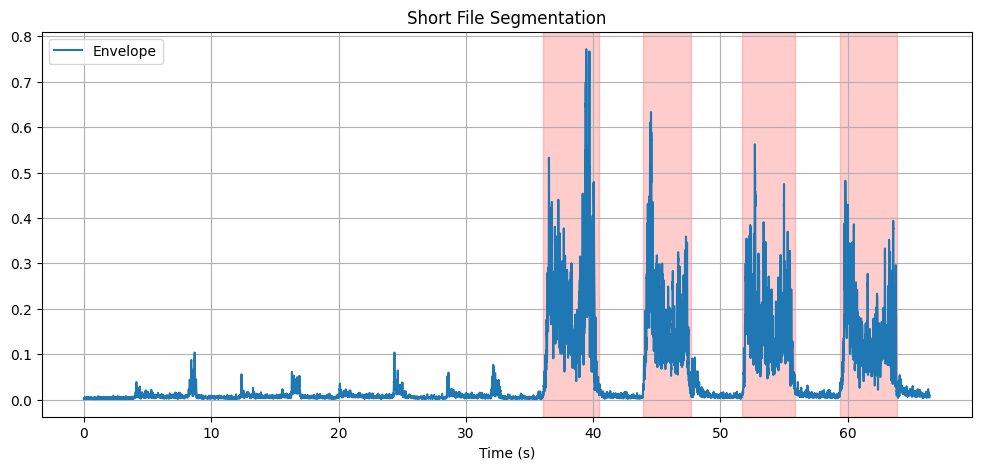

   burst  start_s   end_s  duration       rms       mav        mdf  \
0      1   36.108  40.472     4.364  0.238618  0.167075  87.402344   
1      2   43.916  47.718     3.802  0.203191  0.145820  87.402344   
2      3   51.746  55.896     4.150  0.186747  0.136534  91.308594   
3      4   59.382  63.854     4.472  0.164526  0.118767  93.750000   

   tremor_power condition    label  
0  2.406035e-08   placebo  clench1  
1  8.636525e-09   placebo  clench2  
2  1.968136e-08   placebo  clench3  
3  8.657839e-09   placebo  clench4  


In [8]:
V1 = process_short_auto("/content/BSP_Project_EMG_Caffeine-Violeta-1.acq", "placebo")
print(V1["features"])

Threshold = 0.0117, detected 4 bursts


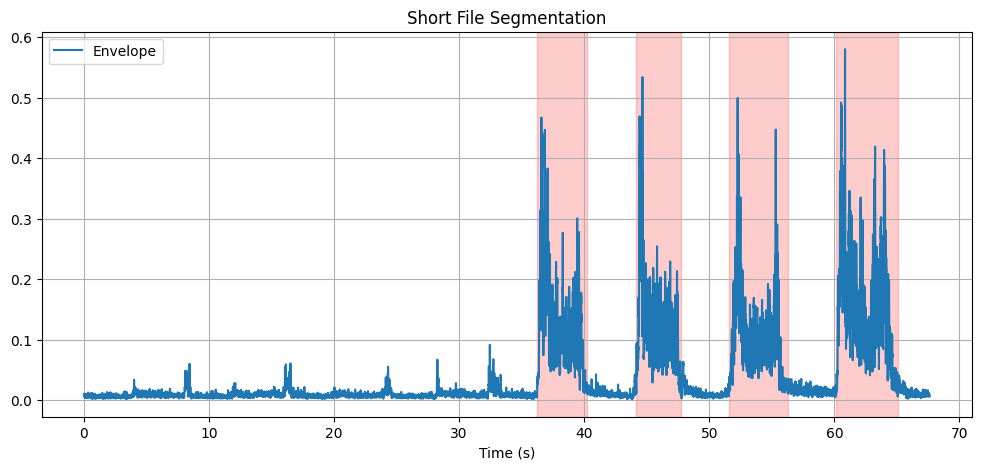

   burst  start_s   end_s  duration       rms       mav        mdf  \
0      1   36.234  40.224     3.990  0.151048  0.104551  96.191406   
1      2   44.162  47.720     3.558  0.147406  0.105041  91.796875   
2      3   51.576  56.290     4.714  0.127973  0.087743  92.773438   
3      4   60.152  65.068     4.916  0.179933  0.128109  88.378906   

   tremor_power condition    label  
0  7.023872e-09  caffeine  clench1  
1  4.354443e-09  caffeine  clench2  
2  3.435891e-09  caffeine  clench3  
3  1.271100e-08  caffeine  clench4  


In [9]:
V2 = process_short_auto("/content/BSP_Project_EMG_Caffeine-Violeta-2.acq", "caffeine")
print(V2["features"])

Threshold = 0.0164, detected 4 bursts


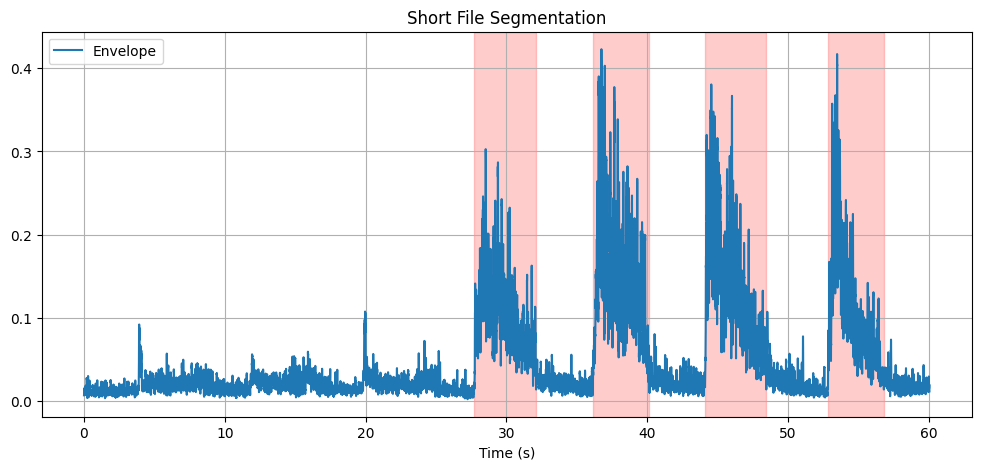

   burst  start_s   end_s  duration       rms       mav         mdf  \
0      1   27.736  32.118     4.382  0.116150  0.087002  113.281250   
1      2   36.150  40.166     4.016  0.168291  0.124098  108.398438   
2      3   44.118  48.464     4.346  0.153585  0.110307  104.003906   
3      4   52.848  56.818     3.970  0.131075  0.090192  112.792969   

   tremor_power condition    label  
0  7.654589e-09  caffeine    lift1  
1  2.406021e-08  caffeine  clench1  
2  1.388520e-08  caffeine  clench2  
3  1.329031e-08  caffeine  clench3  


In [10]:
L1 = process_short_auto("/content/BSP_Project_EMG_Caffeine-Laura-1.acq", "caffeine")
print(L1["features"])

Threshold = 0.0154, detected 4 bursts


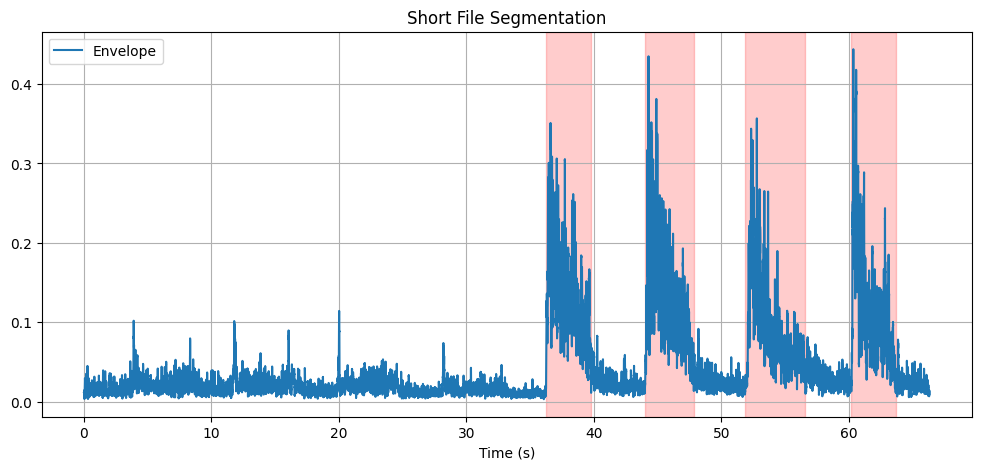

   burst  start_s   end_s  duration       rms       mav         mdf  \
0      1   36.224  39.792     3.568  0.148729  0.111325  110.351562   
1      2   44.016  47.844     3.828  0.149419  0.106877  108.886719   
2      3   51.890  56.612     4.722  0.112127  0.076347  113.769531   
3      4   60.214  63.684     3.470  0.139189  0.097300  113.281250   

   tremor_power condition    label  
0  1.013072e-08   placebo  clench1  
1  1.315951e-08   placebo  clench2  
2  5.239491e-09   placebo  clench3  
3  2.820245e-09   placebo  clench4  


In [11]:
L2 = process_short_auto("/content/BSP_Project_EMG_Caffeine-Laura-2.acq", "placebo")
print(L2["features"])

Threshold = 0.0146, detected 1 bursts


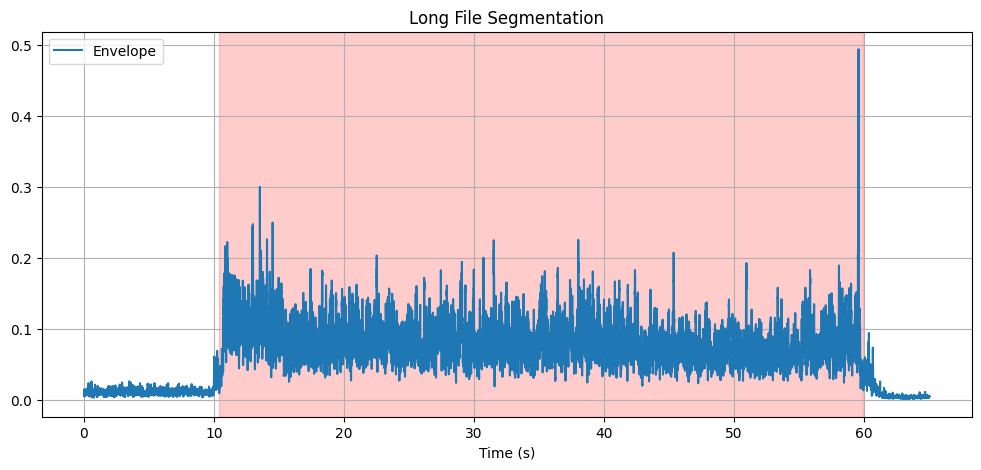

     segment       rms       mav        mdf  tremor_power condition
0  long_task  0.090453  0.069896  88.378906  1.678305e-08   placebo
[100.5859375   92.7734375   84.9609375   83.49609375  86.9140625
  80.078125    81.0546875   83.0078125   79.1015625 ]


In [12]:
Z3 = process_long_auto("/content/BSP_Project_EMG_Caffeine-Zalan-3.acq", "placebo")
print(Z3["features"])
print(Z3["mdf_curve"])

Threshold = 0.0097, detected 1 bursts


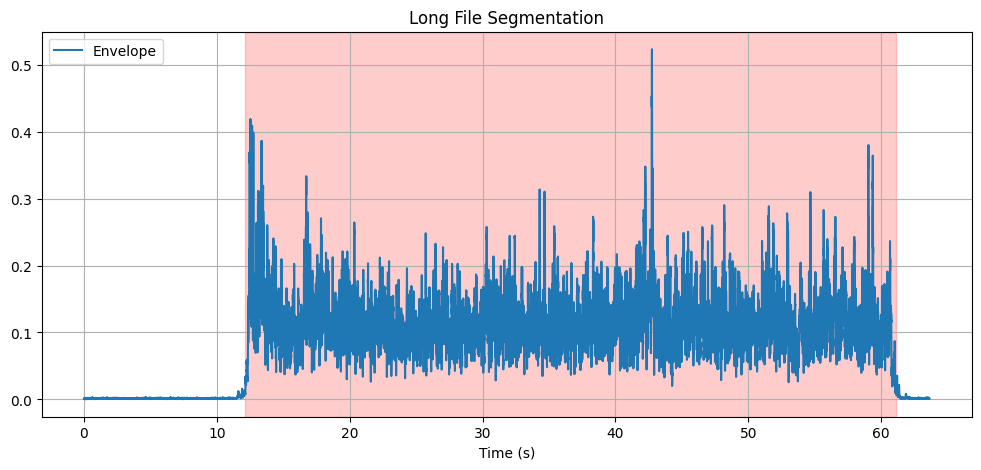

     segment       rms       mav        mdf  tremor_power condition
0  long_task  0.127931  0.098092  64.453125  1.462674e-08  caffeine
[73.73046875 68.359375   71.77734375 70.80078125 60.546875   62.01171875
 42.48046875 66.40625    54.19921875]


In [13]:
B3 = process_long_auto("/content/BSP_Project_EMG_Caffeine-Benedek-3.acq", "caffeine")
print(B3["features"])
print(B3["mdf_curve"])

Threshold = 0.0168, detected 1 bursts


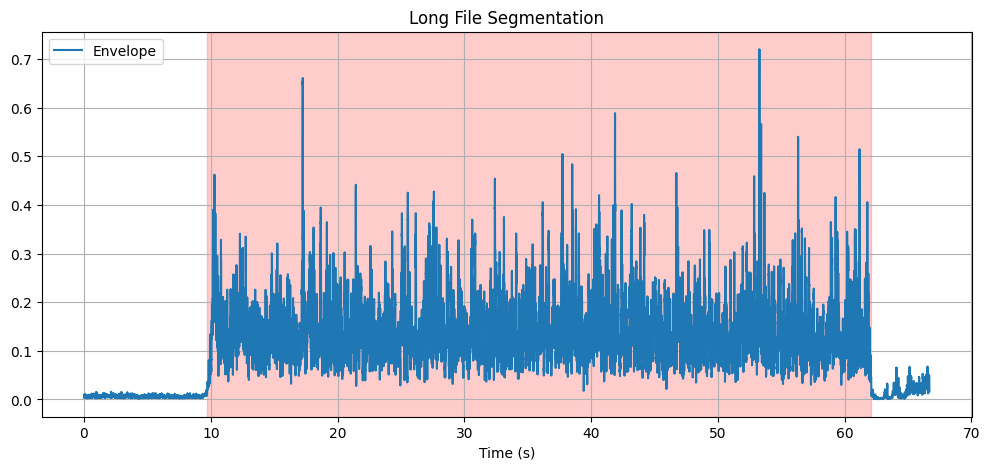

     segment       rms      mav        mdf  tremor_power condition
0  long_task  0.160746  0.12028  79.589844  1.912013e-08  caffeine
[96.6796875  85.44921875 83.984375   79.58984375 78.125      73.73046875
 72.75390625 78.61328125 79.1015625  78.61328125]


In [14]:
V3 = process_long_auto("/content/BSP_Project_EMG_Caffeine-Violeta-3.acq", "caffeine")
print(V3["features"])
print(V3["mdf_curve"])

Threshold = 0.0140, detected 0 bursts


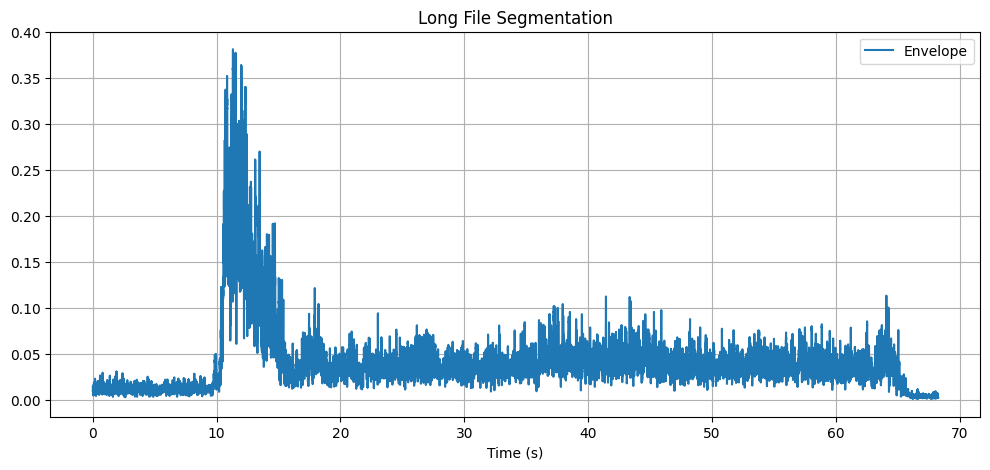

RuntimeError: No activity detected in long protocol.

In [15]:
L3 = process_long_auto("/content/BSP_Project_EMG_Caffeine-Laura-3.acq", "placebo")
print(L3["features"])
print(L3["mdf_curve"])

In [16]:
subjects = ["ZC", "ZP", "BP", "BC", "VP", "VC", "LC", "LP"]

short_objs = {
    "ZC": Z1,
    "ZP": Z2,
    "BP": B1,
    "BC": B2,
    "VP": V1,
    "VC": V2,
    "LC": L1,
    "LP": L2,
}

long_objs = {
    "ZP": Z3,
    "BC": B3,
    "VC": V3,
}

conditions = {
    "ZC": "caffeine",
    "ZP": "placebo",
    "BP": "placebo",
    "BC": "caffeine",
    "VP": "placebo",
    "VC": "caffeine",
    "LC": "caffeine",
    "LP": "placebo",
}

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel, ttest_ind, wilcoxon

sns.set(style="whitegrid", font_scale=1.1)

def paired_arrays(df, feature):
    if df.empty:
        return np.array([]), np.array([])

    pivot = df.pivot(index="base_subject", columns="condition", values=feature)

    needed_cols = [c for c in ["caffeine", "placebo"] if c in pivot.columns]
    if len(needed_cols) < 2:
        return np.array([]), np.array([])

    pivot = pivot.dropna(subset=needed_cols, how="any")
    if pivot.empty:
        return np.array([]), np.array([])

    return pivot["caffeine"].values, pivot["placebo"].values


def build_short_df(subjects, short_objs, conditions):
    rows = []
    for sess_id in subjects:
        sobj = short_objs[sess_id]
        feats = sobj["features"]

        base = sess_id[0]  # 'ZC' -> 'Z'
        cond = conditions[sess_id]

        f = feats.copy()
        f["session"] = sess_id
        f["base_subject"] = base
        f["condition"] = cond
        rows.append(f)

    df_short = pd.concat(rows, ignore_index=True)
    return df_short


def build_long_df(long_objs, conditions):
    rows = []
    for sess_id, lobj in long_objs.items():
        feats = lobj["features"].copy()
        base = sess_id[0]
        cond = conditions[sess_id]

        feats["session"] = sess_id
        feats["base_subject"] = base
        feats["condition"] = cond
        feats["mdf_curve"] = [lobj["mdf_curve"]]

        # fatigue slope from curve
        curve = lobj["mdf_curve"]
        x = np.arange(len(curve))
        slope = np.polyfit(x, curve, 1)[0]
        feats["fatigue_slope"] = slope

        rows.append(feats)

    if rows:
        df_long = pd.concat(rows, ignore_index=True)
    else:
        df_long = pd.DataFrame()
    return df_long

In [18]:
df_short = build_short_df(subjects, short_objs, conditions)
df_long  = build_long_df(long_objs, conditions)

print("Short DF head:")
print(df_short.head())
print("\nLong DF head:")
print(df_long.head())

Short DF head:
   burst  start_s   end_s  duration       rms       mav         mdf  \
0      1    3.042   5.458     2.416  0.044877  0.034655  113.281250   
1      2    9.988  12.314     2.326  0.060956  0.045566  120.117188   
2      3   17.820  21.302     3.482  0.059209  0.044653  110.839844   
3      4   25.536  27.450     1.914  0.047180  0.036793  112.852665   
4      5   34.384  36.368     1.984  0.043950  0.034504   74.092742   

   tremor_power condition    label session base_subject  
0  9.340947e-10  caffeine    lift1      ZC            Z  
1  7.750005e-11  caffeine    lift2      ZC            Z  
2  2.737874e-10  caffeine    lift3      ZC            Z  
3  7.632569e-10  caffeine    lift4      ZC            Z  
4  6.335340e-10  caffeine  clench1      ZC            Z  

Long DF head:
     segment       rms       mav        mdf  tremor_power condition session  \
0  long_task  0.090453  0.069896  88.378906  1.678305e-08   placebo      ZP   
1  long_task  0.127931  0.098092  64.

In [19]:
# Lift segments
df_lift = df_short[df_short["label"].str.contains("lift")]
df_lift_avg = (df_lift
               .groupby(["base_subject", "condition"])
               [["rms", "mdf", "tremor_power"]]
               .mean()
               .reset_index())

# Clench segments
df_clench = df_short[df_short["label"].str.contains("clench")]
df_clench_avg = (df_clench
                 .groupby(["base_subject", "condition"])
                 [["rms", "mdf", "tremor_power"]]
                 .mean()
                 .reset_index())

print("\nLift averages:")
print(df_lift_avg)
print("\nClench averages:")
print(df_clench_avg)



Lift averages:
  base_subject condition       rms         mdf  tremor_power
0            B  caffeine  0.027885  119.791667  3.507265e-10
1            L  caffeine  0.116150  113.281250  7.654589e-09
2            Z  caffeine  0.053055  114.272736  5.121598e-10
3            Z   placebo  0.046265  122.070312  3.450662e-10

Clench averages:
  base_subject condition       rms         mdf  tremor_power
0            B  caffeine  0.141946   80.566406  2.510037e-08
1            B   placebo  0.118780   82.153320  1.133229e-08
2            L  caffeine  0.150984  108.398438  1.707857e-08
3            L   placebo  0.137366  111.572266  7.837491e-09
4            V  caffeine  0.151590   92.285156  6.881302e-09
5            V   placebo  0.198271   89.965820  1.525902e-08
6            Z  caffeine  0.053026   77.085377  2.636979e-09
7            Z   placebo  0.060847   92.163086  2.441544e-09


In [20]:
def report_paired(df, name, feature):
    caf, plc = paired_arrays(df, feature)
    print(f"\n{name} – {feature}")
    if len(caf) == 0:
        print("  No caffeine–placebo pairs available for this.")
        return

    t_p = ttest_rel(caf, plc).pvalue
    w_p = wilcoxon(caf, plc).pvalue
    print(f"  Paired t-test p = {t_p:.4f}")
    print(f"  Wilcoxon p      = {w_p:.4f}")

print("\n=== SHORT TASK STATS ===")
for feat in ["rms", "mdf", "tremor_power"]:
    report_paired(df_lift_avg,   "Lift",   feat)
    report_paired(df_clench_avg, "Clench", feat)



=== SHORT TASK STATS ===

Lift – rms
  Paired t-test p = nan
  Wilcoxon p      = 1.0000

Clench – rms
  Paired t-test p = 0.7937
  Wilcoxon p      = 1.0000

Lift – mdf
  Paired t-test p = nan
  Wilcoxon p      = 1.0000

Clench – mdf
  Paired t-test p = 0.3270
  Wilcoxon p      = 0.3750

Lift – tremor_power
  Paired t-test p = nan
  Wilcoxon p      = 1.0000

Clench – tremor_power
  Paired t-test p = 0.5058
  Wilcoxon p      = 0.3750


/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1243: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1243: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1243: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1243: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1243: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.1

In [24]:
print("\n=== LONG PROTOCOL ===")
print(df_long[["base_subject", "condition", "rms", "mdf", "fatigue_slope"]])

if not df_long.empty:
    for feat in ["rms", "mdf", "fatigue_slope"]:
        caf = df_long[df_long.condition == "caffeine"][feat].values
        plc = df_long[df_long.condition == "placebo"][feat].values
        print(f"\nLong task – {feat}")
        print(f"  caffeine (n={len(caf)}): mean={np.mean(caf):.3f}, std={np.std(caf, ddof=1):.3f}")
        print(f"  placebo  (n={len(plc)}): mean={np.mean(plc):.3f}, std={np.std(plc, ddof=1):.3f}")
        p_ind = ttest_ind(caf, plc, equal_var=False).pvalue
        print(f"  Unpaired t-test p = {p_ind:.4f}")




=== LONG PROTOCOL ===
  base_subject condition       rms        mdf  fatigue_slope
0            Z   placebo  0.090453  88.378906      -2.107747
1            B  caffeine  0.127931  64.453125      -2.522786
2            V  caffeine  0.160746  79.589844      -1.568419

Long task – rms
  caffeine (n=2): mean=0.144, std=0.023
  placebo  (n=1): mean=0.090, std=nan
  Unpaired t-test p = nan

Long task – mdf
  caffeine (n=2): mean=72.021, std=10.703
  placebo  (n=1): mean=88.379, std=nan
  Unpaired t-test p = nan

Long task – fatigue_slope
  caffeine (n=2): mean=-2.046, std=0.675
  placebo  (n=1): mean=-2.108, std=nan
  Unpaired t-test p = nan


/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



=== PLOTS ===


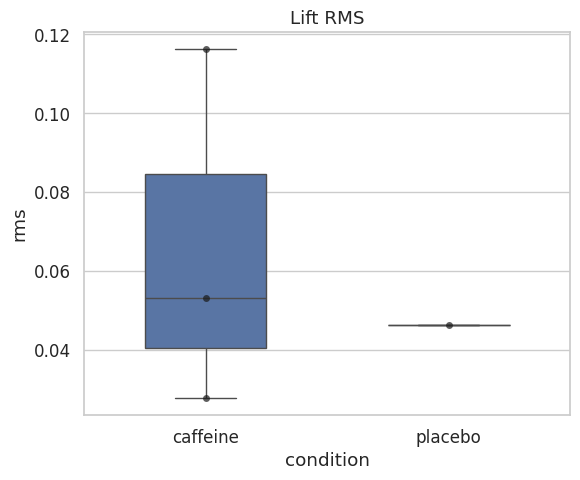

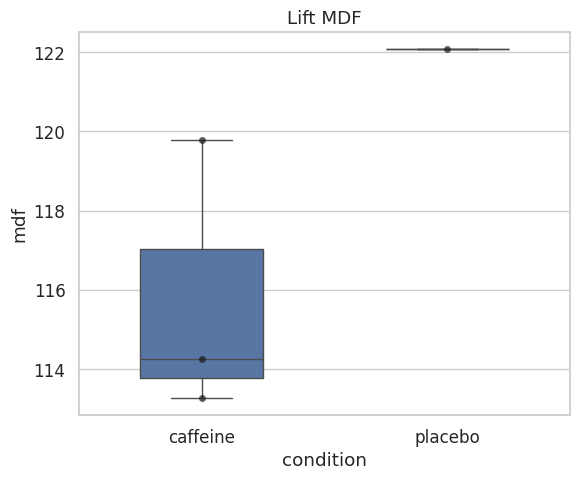

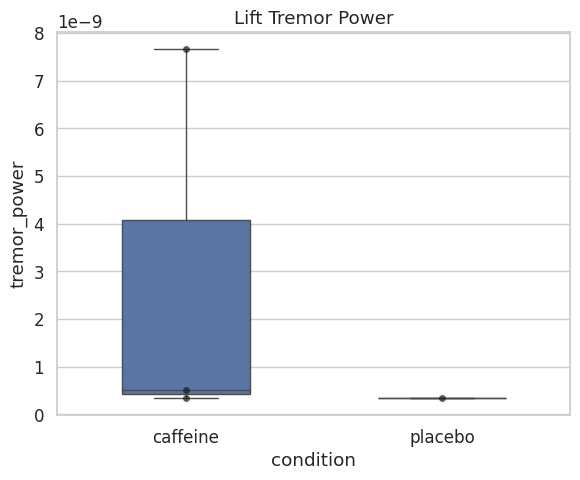

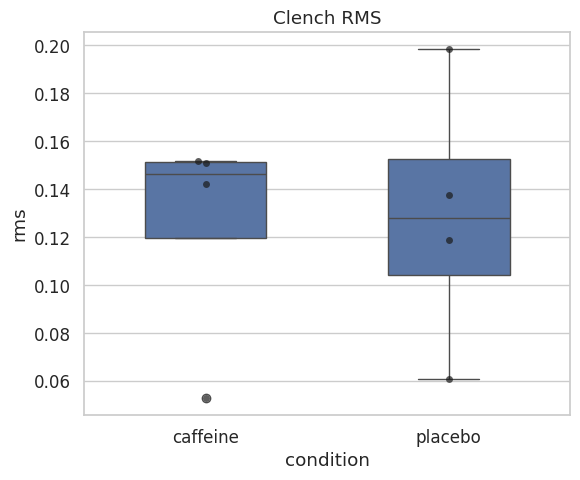

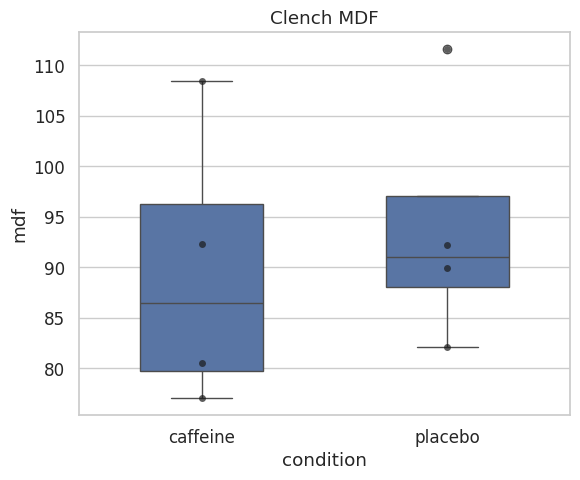

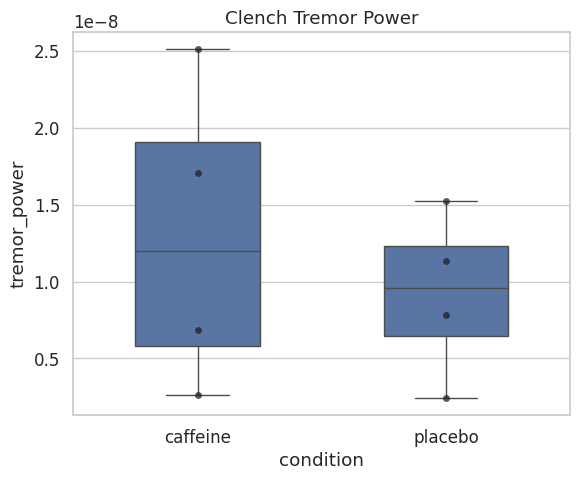

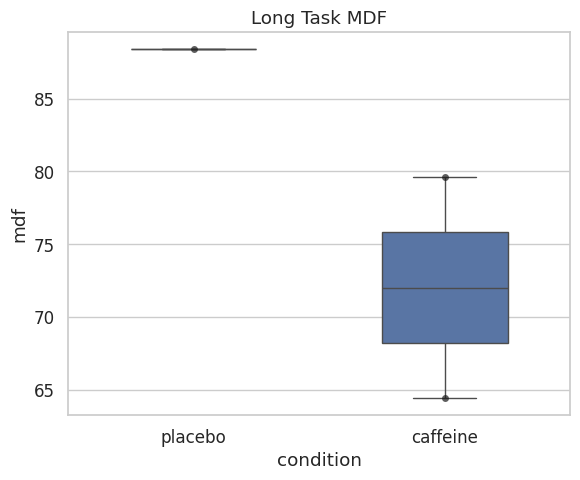

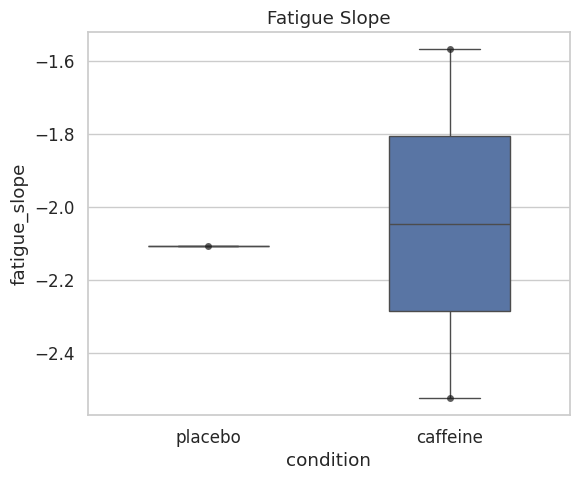

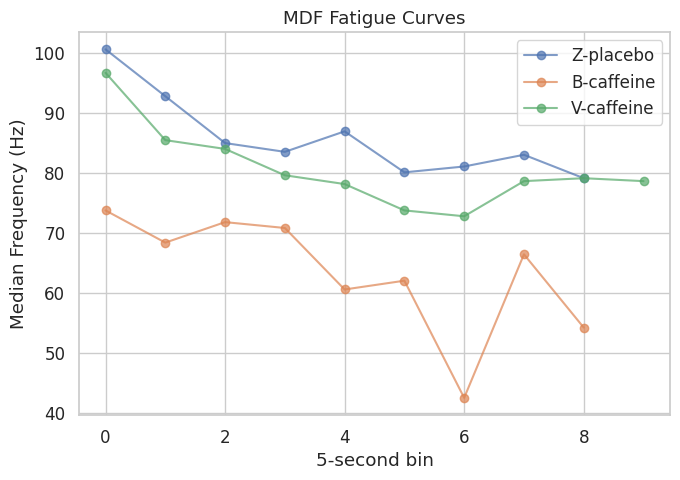

In [22]:
def plot_feature(df, feature, title):
    plt.figure(figsize=(6,5))
    sns.boxplot(data=df, x="condition", y=feature, width=0.5)
    sns.swarmplot(data=df, x="condition", y=feature, color="k", alpha=0.7)
    plt.title(title)
    plt.tight_layout()
    plt.show()

print("\n=== PLOTS ===")
# Short protocol - Lift
plot_feature(df_lift_avg, "rms",          "Lift RMS")
plot_feature(df_lift_avg, "mdf",          "Lift MDF")
plot_feature(df_lift_avg, "tremor_power", "Lift Tremor Power")

# Short protocol - Clench
plot_feature(df_clench_avg, "rms",          "Clench RMS")
plot_feature(df_clench_avg, "mdf",          "Clench MDF")
plot_feature(df_clench_avg, "tremor_power", "Clench Tremor Power")

# Long protocol
if not df_long.empty:
    plot_feature(df_long, "mdf",           "Long Task MDF")
    plot_feature(df_long, "fatigue_slope", "Fatigue Slope")

    # Fatigue curves
    plt.figure(figsize=(7,5))
    for _, row in df_long.iterrows():
        curve = row["mdf_curve"]
        label = f"{row['base_subject']}-{row['condition']}"
        plt.plot(curve, marker="o", alpha=0.7, label=label)
    plt.xlabel("5-second bin")
    plt.ylabel("Median Frequency (Hz)")
    plt.title("MDF Fatigue Curves")
    plt.legend()
    plt.tight_layout()
    plt.show()
